# **Monte Carlo Portfolio Optimization**

In this experiment, I will be using a combination of the Monte Carlo (MC) Simulation and Modern Portfolio Theory (MPT) in attempt to make optimal portfolios for a given look forward period. Using the MC simulation results as a proxy for the market's expected return for the look forward period, I will construct a portfolio of one risky asset (the market portfolio) and a risk-free asset (US treasuries).<br>

*   The market portfolio is "^GSPC", which is the S&P 500
*   The risk-free rate is "^IRX", which is the 13-week T-Bill rate

Lets start with an example before implementing the experiment above.

In [1]:
!pip install yfinance
!pip install pandas
!pip install matplotlib
!pip install numpy
!pip3 install scipy

In [2]:
# Package Imports
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import norm

In [3]:
# Download Market Data
market_data = yf.download(tickers = "^GSPC", period = "max", interval = "1d")

# Download 13-week T-Bill Rates
rates_data = yf.download(tickers = "^IRX", period = "max", interval = "1d")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


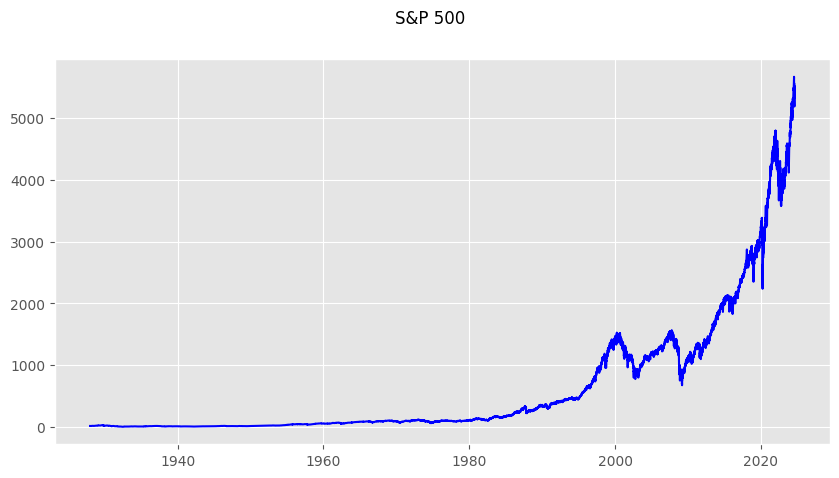

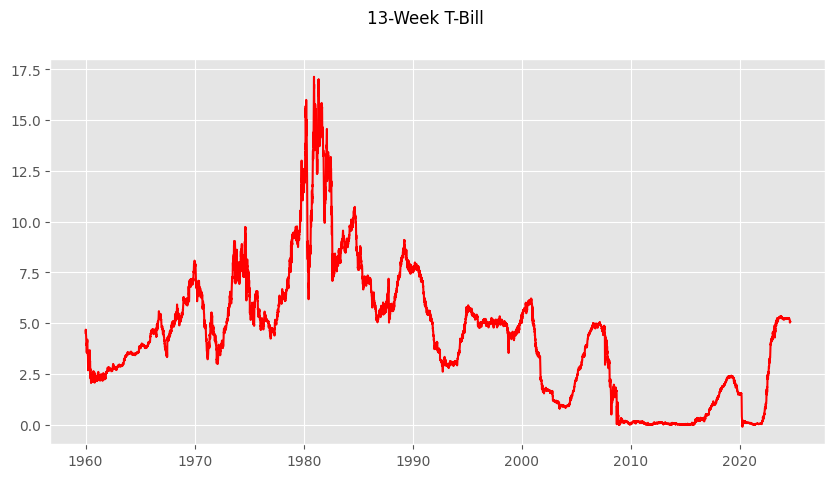

In [4]:
# Plot the data
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('S&P 500')
plt.plot(market_data['Adj Close'], c="blue")
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('13-Week T-Bill')
plt.plot(rates_data['Adj Close'], c="red")
plt.show()

In [5]:
# Convert the dates to datetimes
market_data['pd_date'] = pd.to_datetime(market_data.index)
rates_data['pd_date'] = pd.to_datetime(rates_data.index)

# Merge the dataframes using the common dates
data = pd.merge(market_data, rates_data, on='pd_date')
data.rename(columns={'Adj Close_x' : 'SPY', 'Adj Close_y' : 'Rate', 'pd_date' : 'Date'}, inplace=True)
data = data[['Date', 'SPY', 'Rate']]
data.set_index('Date', inplace=True)

# Only using the last year of data
test_data = data
data = data.iloc[-252:]

print(data.head(10))

                    SPY   Rate
Date                          
2023-08-15  4437.859863  5.280
2023-08-16  4404.330078  5.285
2023-08-17  4370.359863  5.278
2023-08-18  4369.709961  5.278
2023-08-21  4399.770020  5.280
2023-08-22  4387.549805  5.295
2023-08-23  4436.009766  5.295
2023-08-24  4376.310059  5.303
2023-08-25  4405.709961  5.315
2023-08-28  4433.310059  5.323


<ipython-input-6-cd451eb155d8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['log_return'] = np.log(1 + data['SPY'].pct_change())


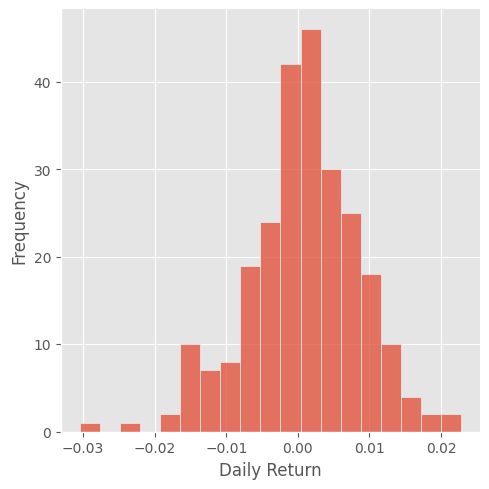

In [6]:
# Calculate the logarithmic market returns
data['log_return'] = np.log(1 + data['SPY'].pct_change())

# Plot the logarithmic return distribution
sns.displot(data['log_return'])
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()

# **Part 1: Brownian Motion & Monte Carlo**
Brownian motion is a stochastic process used for modeling a random process in time space. Excluding the mathematical definitions and rigor, Brownian Motion has two key characteristics that generate the process: *drift* and *volatility*<br>


1. Drift measures the directionality of the returns over the historical period.<br>
$Drift = μ - \frac{1}{2} * σ^2$

2. Volatility is the historical volatility multiplied be the random standard normal variable.<br>
$Volatility = σ * Ζ[\text{Rand(0;1)}]$


$r = Drift + Volatility$<br>
$r = (μ - \frac{1}{2} * σ^2) + (σ * Ζ[\text{Rand(0;1)}])$<br><br>

To calculate the simulated step for time $t$, we use the previous step from $t-1$.<br>
$S_t = S_{t-1} * e^r$<br>
$S_t = S_{t-1} * e^{(μ - \frac{1}{2} * σ^2) + (σ * Ζ[\text{Rand(0;1)}])}$

In [7]:
# Compute the drift and volatility
mu = data['log_return'].mean()
sigma = data['log_return'].std()

drift = mu - (0.5 * sigma ** 2)

print(drift)

0.0007914847092314875


In [8]:
# Simulate N days (3 months) into the future
n = 63
trials = 500

# WHAT DOES THIS FUNCTION DO??
Z = norm.ppf(np.random.rand(n, trials))

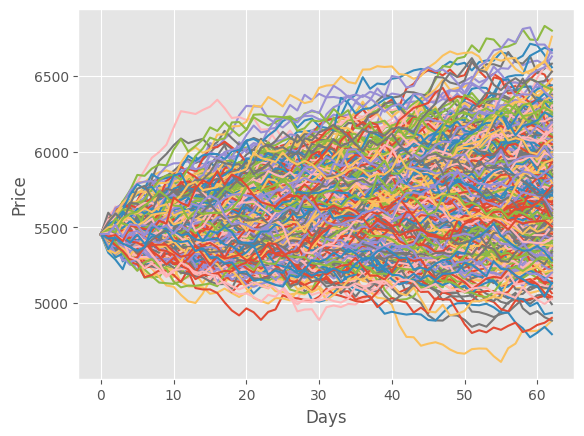

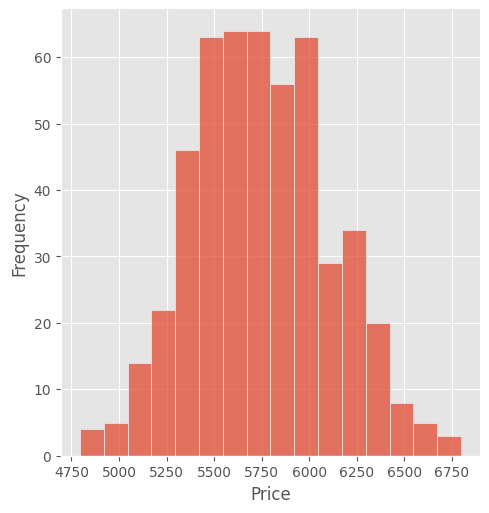

In [9]:
# Simulate the future daily returns
returns = np.exp(drift + sigma * Z)

# Create empty price matrix (to track future prices)
prices = np.zeros_like(returns)
prices[0] = data['SPY'].iloc[-1] # Using the last S&P 500 price

# Calculate the future prices
for t in range(1, n):
  prices[t] = prices[t - 1] * returns[t]

# Plot the prices
plt.plot(prices)
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()

# Plot the prices distribution (of the last day to speed up execution)
sns.displot(prices[-1])
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# **Part 2: Modern Portfolio Theory**<br>
In MPT, the objective is to optimize portfolio weights of N risky assets. Because we have the market portfolio and a risk-free asset, our optimization will befocusing on the *asset allocation* step.<br>

The complete portfolio is goven by:<br>
$E(r_c) = r_f + w_p*(E(r_p)-r_f)$<br>
$σ_c = w_p * σ_p$<br><br>
Where,<br>
$E(r_p)$$~$ is the expected return on the risky portfolio<br>
$σ_p$$~~~~~~~$   is the volatility of the risky portfolio<br>
$r_f$$~~~~~~~$    is the risk-free rate<br>
$w_p$$~~~~~~$    is the percent of total capital invested in the risky portfolio<br>
$E(r_c)$$~$ is the expected return of the complete portfolio<br>
$σ_c$$~~~~~~~$    is the volatility of the complete portfolio<br><br>

Since we want to know the portion of the portfolio to invest in the market, we must draw from study of utility theory. Because this is out of scope for this example, we will assume that our agent has a risk-aversion coefficient of $A=2$. It is important to note that higher values of $A$ are more risk-averse and will subsequently lead to lower risky portfolio weights.<br>
Solving for $w_p$,<br>
$w_p = \frac{E(r_p)-r_f}{A*σ_p^2}$<br>


In [10]:
A = 2

# Extract the current 13-week (3-month) risk-free rate
r_f = data['Rate'].iloc[-1] / 100
r_f = (1 + r_f) ** (0.25) - 1

# Calculate the market's expected return
priceDf = pd.DataFrame(prices)
E_r = (priceDf.iloc[-1].mean() - priceDf.iloc[0,1]) / priceDf.iloc[0,1]
sigma_p = sigma * np.sqrt(252)

w_p = (E_r - r_f) / (A * sigma_p ** 2) # Weight of risk portfolio

print(f'Weight: {w_p}')

# Calculate the complete portfolio's E_r and sigma
E_c = r_f + w_p * (E_r - r_f)
sigma_c = w_p * sigma_p

print(f'Expected Return(C): {E_c}')
print(f'Volatility:         {sigma_c}')

Weight: 1.3616587457702236
Expected Return(C): 0.07002782195959667
Volatility:         0.16971119639045856


# **Part 3: Putting It All Together**
Now that we have the foundation for Brownian Motion, Monte Carlo Simulation, and Portfolio Optimization, lets combine them.<br>
In this experiment, the MC Simulation will be the proxy for optimizing the market portfolio weight.<br><br>
*Important Notes:*<br>
$w_p < 0$ indicates short position<br>
$w_p > 1$ indicates a long position with leverage<br>
As is standard for a margin account, we are limiting the maximum leverage to 2.0.<br>
The actual return of the test will be ***UNDERSTATED*** because I am ommiting the return generated by the risk-free asset for simplicity.

In [30]:
data = test_data

data['SPY_return'] = np.log(1 + data['SPY'].pct_change())              # Calculate the daily market returns
data['Rate'] = data['Rate'] / 100                          # Convert the rate to percentage form
data['Rate_annualized'] = (1 + data['Rate']) ** (0.25) - 1 # Annualize the 13-week rate

# Identify new months
data['Date'] = pd.to_datetime(data.index)
data['Month'] = data['Date'].dt.to_period('M')
data['P_Month'] = data['Month'].shift(-1)            # Processing on close of old month
data['New_Month'] = data['Month'] != data['P_Month']

data.drop(columns=['Date', 'Month', 'P_Month'], inplace=True)
data.dropna(inplace=True, axis=0)

# MC Simulation Constants
N = 63
TRIALS = 500
LOOKBACK = 126

# Portfolio Optimization Constants
A = 2
MAX_LEVERAGE = 2.0

risky_weight = 0
data['C_Returns'] = 0

for i in range(LOOKBACK, len(data)):
  # If new month
  if data['New_Month'].iloc[i]:
    mu = data['SPY_return'].iloc[i - LOOKBACK : i].mean()
    sigma = data['SPY_return'].iloc[i - LOOKBACK : i].std()

    # Simulate returns
    drift = mu - (0.5 * sigma ** 2)
    Z = norm.ppf(np.random.rand(N, TRIALS))
    returns = np.exp(drift + sigma * Z)

    # Simulate prices
    prices = np.zeros_like(returns)
    prices[0] = data['SPY'].iloc[i - 1]

    for t in range(1, N):
      prices[t] = prices[t - 1] * returns[t]

    prices = pd.DataFrame(prices)

    # Calculate the optimal portfolio
    r_f = data['Rate_annualized'].iloc[i]

    E_r = (prices.iloc[-1].mean() - prices.iloc[0,1]) / prices.iloc[0,1]
    sigma_p = sigma * np.sqrt(252)

    w_p = (E_r - r_f) / (A * sigma_p ** 2)
    risky_weight = min(MAX_LEVERAGE, w_p)

  # Calculate daily returns (excluding the risk-free asset for simplicity)
  data['C_Returns'].iat[i] = risky_weight * data['SPY_return'].iat[i]

<ipython-input-30-97995290ed74>:58: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.01799230094491308' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data['C_Returns'].iat[i] = risky_weight * data['SPY_return'].iat[i]


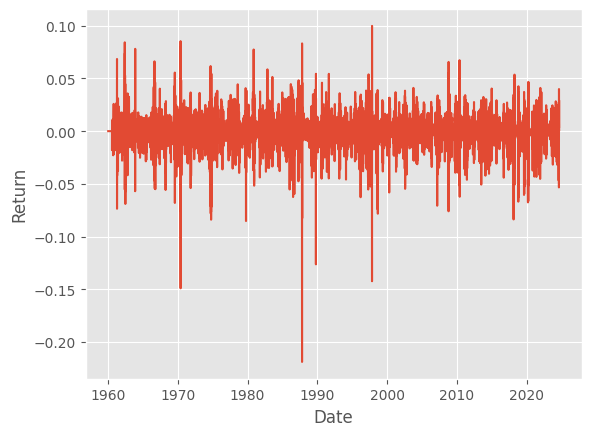

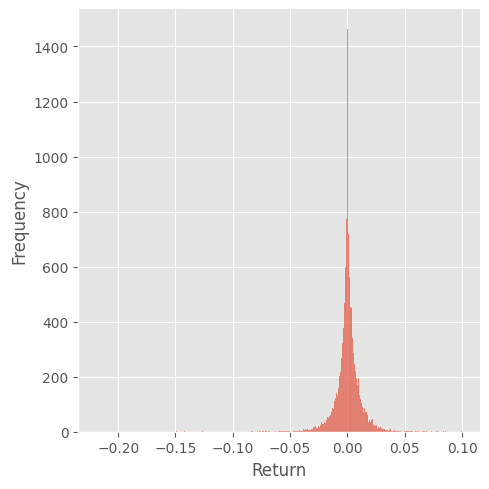

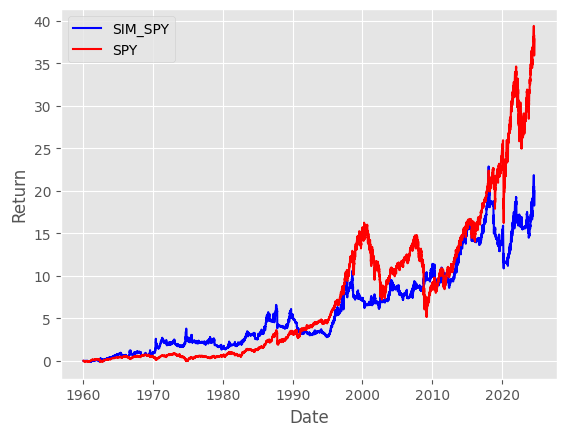

In [31]:
# Plot the returns
plt.plot(data['C_Returns'])
plt.xlabel('Date')
plt.ylabel('Return')
plt.show()

# Plot the returns distribution
sns.displot(data['C_Returns'])
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.show()

# Plot cummulative returns
plt.plot(((data['C_Returns'] + 1).cumprod() - 1), c='blue', label='SIM_SPY')
plt.plot(((data['SPY_return'] + 1).cumprod() - 1), c='red', label='SPY')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Return')
plt.show()

In [33]:
# Simulation return characteristics
mean = data['C_Returns'].mean()
std = data['C_Returns'].std()
var = data['C_Returns'].var()
skew = data['C_Returns'].skew()
kurt = data['C_Returns'].kurt()

print(f'Simulation Mean: {mean}')
print(f'Simulation Std:  {std}')
print(f'Simulation Var:  {var}')
print(f'Simulation Skew: {skew}')
print(f'Simulation Kurt: {kurt}')

Simulation Mean: 0.00025366829982124257
Simulation Std:  0.01135125715901352
Simulation Var:  0.00012885103909005569
Simulation Skew: -1.1119374979395942
Simulation Kurt: 20.289215831153626


# **Conclusion**<br>
While far from a viable investment strategy, it was an insightful experiment as to using MC Simulations as a proxy for expected market returns over a look-forward period.<br>
Further improvements can be made to this experiment.


1.   Include the risk-free return to the portfolio returns
2.   Dynamic risk-aversion coefficient based on previous volatility

